# Analysis og TCGA data with DeepMapper 

This notebook runs DeepMapper with the TCGA data that DeepInsight used as a benchmark

## Import Libraries


In [1]:

from pyDeepMapper import DeepMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, scale, minmax_scale
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [2]:
import random
seed=12345
random.seed(seed)

In [3]:
datafilename = 'pocdata-fin.pickle'


In [18]:
import pickle
with open('tcgadata.pickle', 'rb') as data_file:
    data = pickle.load(data_file)
    X=data['X']
    y=data['y'], 
    feature_names=data['feature_names']
    obs_names=data['obs_names']
    class_names=list(data['class_names'])

In [19]:
feature_names

['A1BG',
 'A1CF',
 'A2BP1',
 'A2LD1',
 'A2ML1',
 'A2M',
 'A4GALT',
 'A4GNT',
 'AAA1',
 'AAAS',
 'AACSL',
 'AACS',
 'AADACL2',
 'AADACL3',
 'AADACL4',
 'AADAC',
 'AADAT',
 'AAGAB',
 'AAK1',
 'AAMP',
 'AANAT',
 'AARS2',
 'AARSD1',
 'AARS',
 'AASDHPPT',
 'AASDH',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA10',
 'ABCA11P',
 'ABCA12',
 'ABCA13',
 'ABCA17P',
 'ABCA1',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCB10',
 'ABCB11',
 'ABCB1',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC13',
 'ABCC1',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6P1',
 'ABCC6P2',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD10',
 'ABHD11',
 'ABHD12B',
 'ABHD12',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD15',
 'ABHD1',
 'ABHD2',
 'ABHD3',
 'ABHD4',
 'ABHD5',
 'ABHD6',
 'ABHD8',
 'ABI1',
 'ABI2',
 'ABI3B

In [20]:
y=y[0]
y

array(['BRCA', 'BRCA', 'BRCA', ..., 'THCA', 'THCA', 'THCA'], dtype=object)

In [21]:
X_norm = X
#X_norm = scale(X, axis=0, with_mean=True, with_std=True, copy=True)
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array(['BRCA', 'HNSC', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'THCA'],
       dtype=object),
 array([1093,  520,  533,  516,  515,  501,  501]))

In [22]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(y_enc)
num_classes = np.unique(y_enc).size
print(num_classes, class_names)

[0 0 0 ... 6 6 6]
7 ['BRCA', 'HNSC', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'THCA']


In [23]:
%%time
X_img = DeepMapper.map(X)

CPU times: user 494 ms, sys: 206 ms, total: 700 ms
Wall time: 701 ms


In [24]:
X_img.shape

(4179, 139, 139, 1)

The following are showing plots for the image matrices first four samples 
of the training set. 

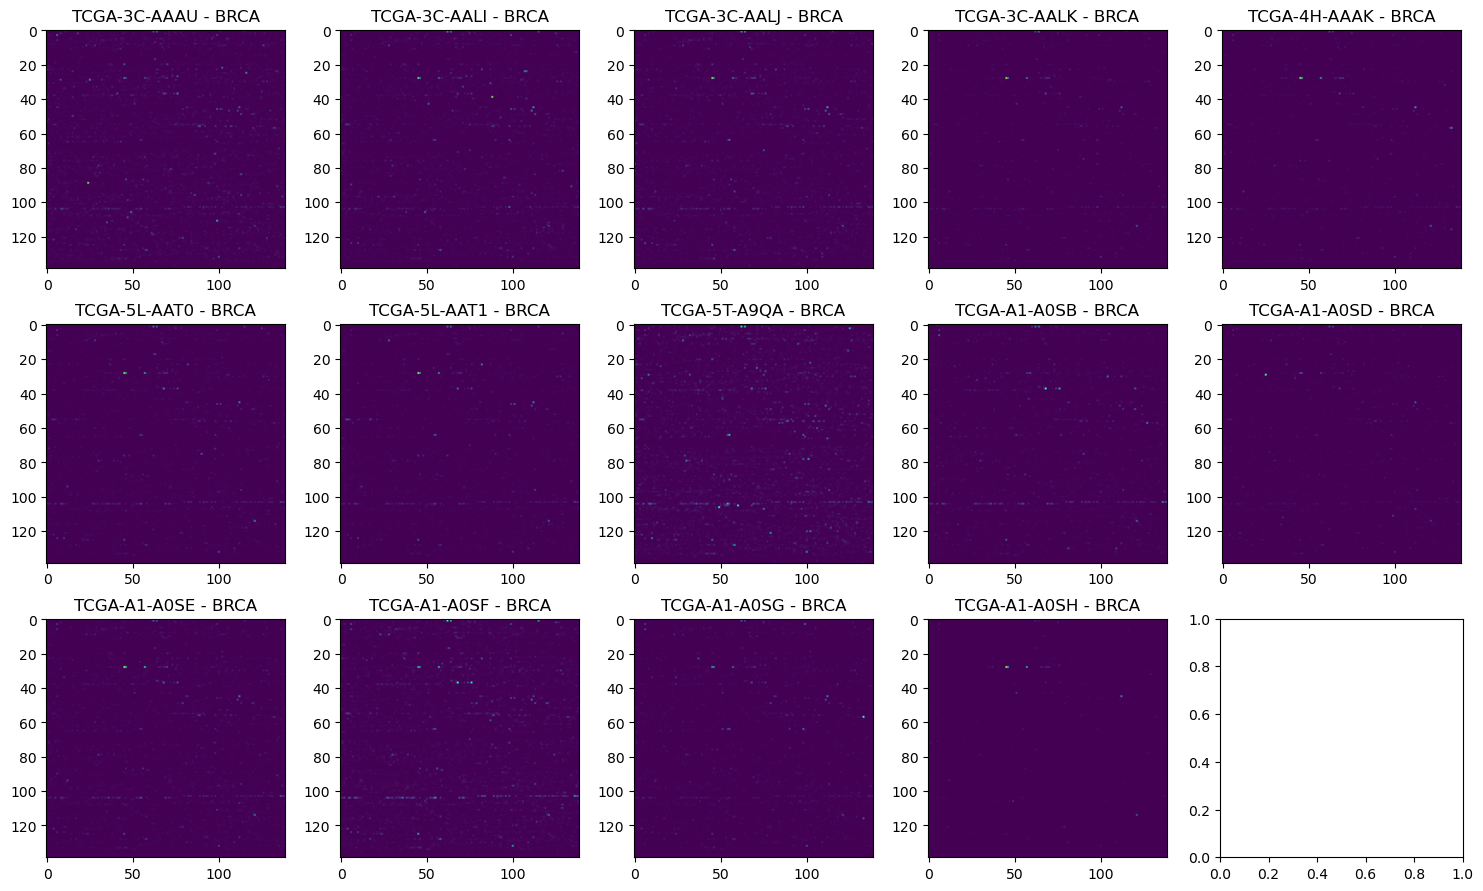

In [27]:
pics=14
num_images_per_row = 5
num_cols=pics // num_images_per_row + 1
fig, ax = plt.subplots(num_cols, num_images_per_row, figsize=(15, 3 * num_cols))
for i in range(0,pics):
    row= i // num_images_per_row
    col=i % num_images_per_row
    ax[row,col].imshow(X_img[i])
    ax[row,col].title.set_text(f"{obs_names[i]} - {class_names[y_enc[i]]}")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

## Training

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Transform numpy image format to PyTorch tensor. 

In [29]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3, -1, -1))
])

def create_tensors_from(X,y):
    X_tensor = torch.stack([preprocess(elm) for elm in X]).float()
    y_tensor = torch.from_numpy(le.fit_transform(y))
    return(X_tensor, y_tensor)



Generate pyTorch datasets and dataloaders for training and testing sets.

In [30]:

def load_batch(dataset,  batch_size):
    return(DataLoader(dataset, batch_size=batch_size, shuffle=True))

Specify loss function and optimization algorithm

In [31]:
def set_model(num_classes,pretrained=False):
#    model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=pretrained)
    model = torchvision.models.resnet18(pretrained=pretrained)
    num_features = model.fc.in_features     #extract fc layers features
    model.fc = nn.Linear(num_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    return(model)

In [32]:
 def set_run_params(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-03,
        #momentum=0.8,
        weight_decay=1e-05
    )
    return((criterion, optimizer))

##Train

In [33]:

def train(model,epochs,trainloader, testloader,criterion,optimizer,training_data_size, batch_size=100):
    model.train()
    model.to(device)
    for epoch in range(1,epochs+1):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print epoch statistics
#        if not (epoch % 10):
#            print(f'[{epoch}] loss: {running_loss / training_data_size * batch_size:.3f}')
    print(f'End training. Loss: {running_loss / training_data_size * batch_size:.3f}')
    return (outputs)


In [34]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [35]:
from captum.attr import IntegratedGradients, Saliency, GradientShap, DeepLift, InputXGradient,LRP
import torch.nn.functional as F
def deepmap(X, y, num_epochs, num_passes, batch_size, max_vars, min_accuracy=0.79, max_tries=20):
    results=[]
    imps=[]
    passes=0
    tries=0
    prediction_score=[]
    X_tensor, y_tensor = create_tensors_from(X,y)
    for i in range(0,num_passes):
        tries = tries+1
        model=set_model(num_classes)
        criterion,optimizer=set_run_params(model)
        X_train_tensor,X_test_tensor,y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.25, shuffle=True)
        train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor,y_test_tensor)
        trainloader = load_batch(train_dataset,  batch_size)
        testloader = load_batch(test_dataset,  batch_size)
        train(model,num_epochs,trainloader, testloader,criterion,optimizer, len(X_train_tensor),batch_size=batch_size)
        model.to('cpu')
        model = model.eval()
        with torch.no_grad():
            y_hat = model(X_train_tensor)
        train_predicted = torch.max(y_hat, 1)[1]
        with torch.no_grad():
            y_hat = model(X_test_tensor)
        test_predicted = torch.max(y_hat, 1)[1]
        train_accuracy = accuracy_score(train_predicted.cpu(), y_train_tensor)
        test_accuracy = accuracy_score(test_predicted, y_test_tensor)
        print(f"The train accuracy was {train_accuracy:.3f}")
        print(f"The test accuracy was {test_accuracy:.3f}")
        if test_accuracy >= min_accuracy:
            if not (passes % (num_passes // 5)):
                _ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=class_names)
            plt.show()
            set_parameter_requires_grad(model, True)
            model.cpu()
            output = model(X_test_tensor)
            output = F.softmax(output, dim=1)
            prediction_score, pred_label_idx = torch.topk(output, 1)
            pred_label_idx.squeeze_()
            #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
            print(np.unique(pred_label_idx, return_counts=True))
            X_test_tensor.cpu()
            model.cpu()
            X_test_tensor.requires_grad_()
            ig = Saliency(model)
            attrs={}
            targets=np.unique(test_predicted.cpu().numpy()).tolist()
            print (targets)
            for target in targets:
                print('Target to be done:',target)
                attr = ig.attribute(X_test_tensor,target=target)#, return_convergence_delta=True)
                attr = attr.mean(axis=0).unsqueeze(0)
                attr = attr.detach()
                attrs[target]=attr
            results.append(attrs)
            attlists={}
            for key,attr in attrs.items():
                attlist=np.sum(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2).flatten()
                attindex=np.array(range(0,len(attlist)))
                attlists[key]=attlist
            names =  ['Var'+str(i) for i in range(0,len(y))]
            maxdet=max_vars
            imp={}
            for key,attlist in attlists.items():
                maxX=[]
                maxV=[]
                for i in range(0,maxdet):
                    idxmax=np.abs(attlist).argmax()
                    fn = 'none' if idxmax >= len(feature_names) else feature_names[idxmax]
#                    print(fn,idxmax, attlist[idxmax])
                    maxX.append(idxmax)
                    maxV.append(attlist[idxmax])
                    attlist[idxmax]=0
                imp[key]=(maxX,maxV)
            imps.append(imp)
            passes = passes+1
        else: 
            print ('Test accuracty is not satisfactory')
    return((model,results,imps, X_test_tensor, prediction_score))


End training. Loss: 0.027
The train accuracy was 0.999
The test accuracy was 0.967


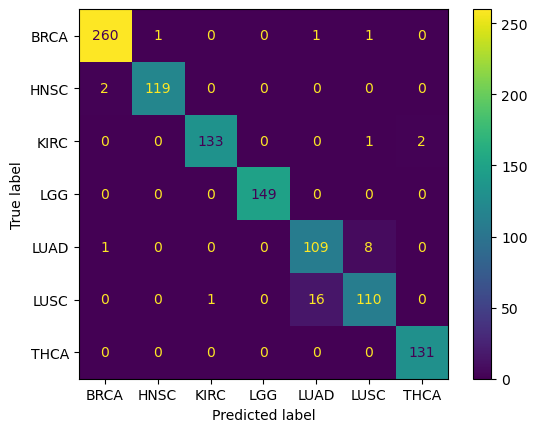

(array([0, 1, 2, 3, 4, 5, 6]), array([263, 121, 136, 149, 118, 127, 131]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.010
The train accuracy was 0.998
The test accuracy was 0.977
(array([0, 1, 2, 3, 4, 5, 6]), array([289, 131, 125, 122, 138, 123, 117]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.003
The train accuracy was 1.000
The test accuracy was 0.973


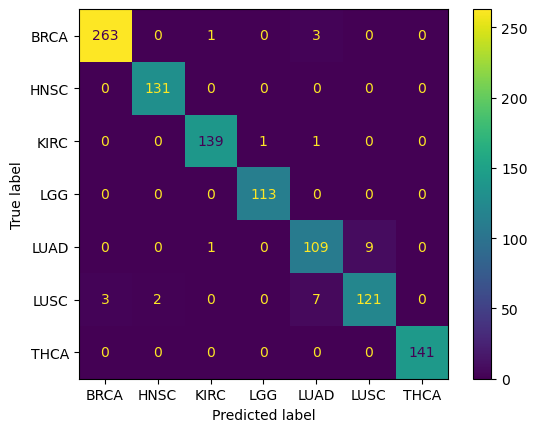

(array([0, 1, 2, 3, 4, 5, 6]), array([267, 131, 141, 113, 119, 133, 141]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.028
The train accuracy was 0.995
The test accuracy was 0.966
(array([0, 1, 2, 3, 4, 5, 6]), array([272, 130, 133, 133, 135, 115, 127]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.021
The train accuracy was 0.998
The test accuracy was 0.974


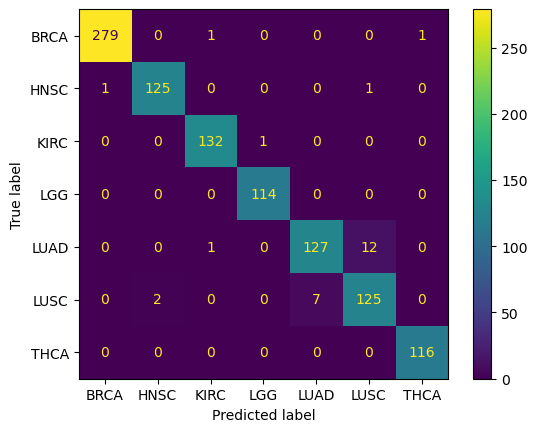

(array([0, 1, 2, 3, 4, 5, 6]), array([281, 127, 133, 114, 140, 134, 116]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.036
The train accuracy was 0.997
The test accuracy was 0.976
(array([0, 1, 2, 3, 4, 5, 6]), array([291, 133, 132, 128, 128, 106, 127]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.039
The train accuracy was 0.989
The test accuracy was 0.968


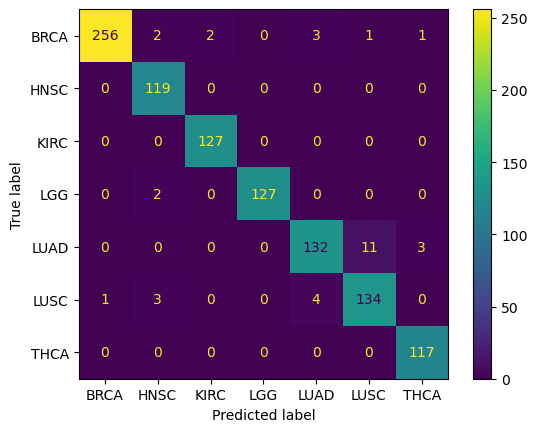

(array([0, 1, 2, 3, 4, 5, 6]), array([265, 119, 127, 129, 146, 142, 117]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.031
The train accuracy was 0.993
The test accuracy was 0.956
(array([0, 1, 2, 3, 4, 5, 6]), array([289, 148, 123, 142, 123, 102, 118]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.037
The train accuracy was 0.999
The test accuracy was 0.972


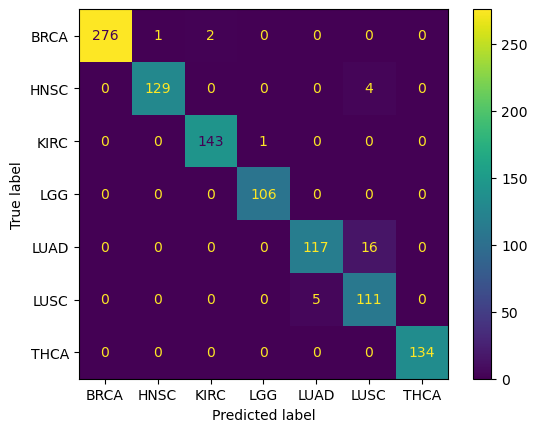

(array([0, 1, 2, 3, 4, 5, 6]), array([279, 133, 144, 106, 133, 116, 134]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6
End training. Loss: 0.012
The train accuracy was 0.996
The test accuracy was 0.974
(array([0, 1, 2, 3, 4, 5, 6]), array([277, 107, 137, 127, 126, 132, 139]))
[0, 1, 2, 3, 4, 5, 6]
Target to be done: 0
Target to be done: 1
Target to be done: 2
Target to be done: 3
Target to be done: 4
Target to be done: 5
Target to be done: 6


In [36]:
model,results,imps, test_input, test_=deepmap(X_img, y_enc, 15,10, 20, 20, min_accuracy= 0.8)

In [37]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from importlib import reload

In [38]:
i=0
sums=[[]] * len(results[0])
for attrs in results:
    for key,att in attrs.items():
        arr=np.transpose(att.squeeze().cpu().detach().numpy(), (1,2,0))
        if sums[key]==[]:
            sums[key]=arr
        else:
            sums[key]=sums[key]+arr
        print(i,key,sums[key].shape)
        i=i+1

0 0 (139, 139, 3)
1 1 (139, 139, 3)
2 2 (139, 139, 3)
3 3 (139, 139, 3)
4 4 (139, 139, 3)
5 5 (139, 139, 3)
6 6 (139, 139, 3)
7 0 (139, 139, 3)
8 1 (139, 139, 3)
9 2 (139, 139, 3)
10 3 (139, 139, 3)
11 4 (139, 139, 3)
12 5 (139, 139, 3)
13 6 (139, 139, 3)
14 0 (139, 139, 3)
15 1 (139, 139, 3)
16 2 (139, 139, 3)
17 3 (139, 139, 3)
18 4 (139, 139, 3)
19 5 (139, 139, 3)
20 6 (139, 139, 3)
21 0 (139, 139, 3)
22 1 (139, 139, 3)
23 2 (139, 139, 3)
24 3 (139, 139, 3)
25 4 (139, 139, 3)
26 5 (139, 139, 3)
27 6 (139, 139, 3)
28 0 (139, 139, 3)
29 1 (139, 139, 3)
30 2 (139, 139, 3)
31 3 (139, 139, 3)
32 4 (139, 139, 3)
33 5 (139, 139, 3)
34 6 (139, 139, 3)
35 0 (139, 139, 3)
36 1 (139, 139, 3)
37 2 (139, 139, 3)
38 3 (139, 139, 3)
39 4 (139, 139, 3)
40 5 (139, 139, 3)
41 6 (139, 139, 3)
42 0 (139, 139, 3)
43 1 (139, 139, 3)
44 2 (139, 139, 3)
45 3 (139, 139, 3)
46 4 (139, 139, 3)
47 5 (139, 139, 3)
48 6 (139, 139, 3)
49 0 (139, 139, 3)
50 1 (139, 139, 3)
51 2 (139, 139, 3)
52 3 (139, 139, 3)
53 

0


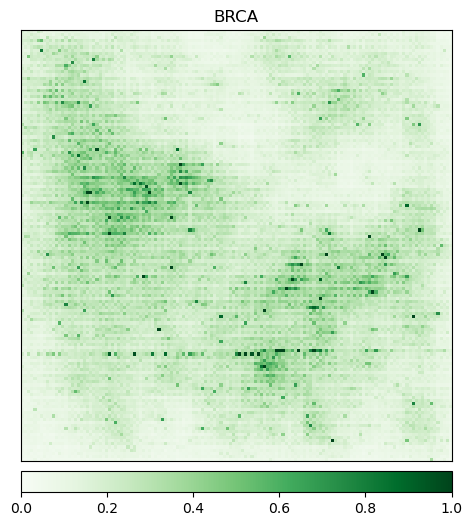

1


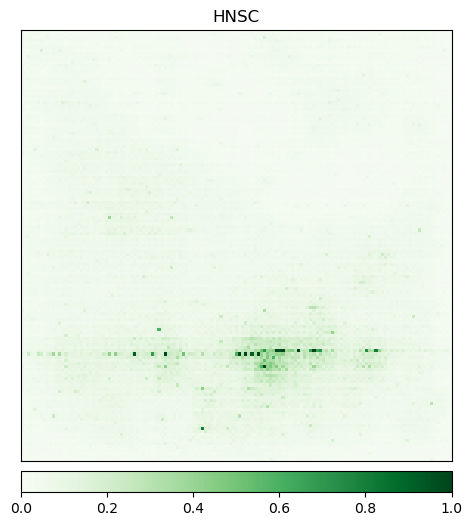

2


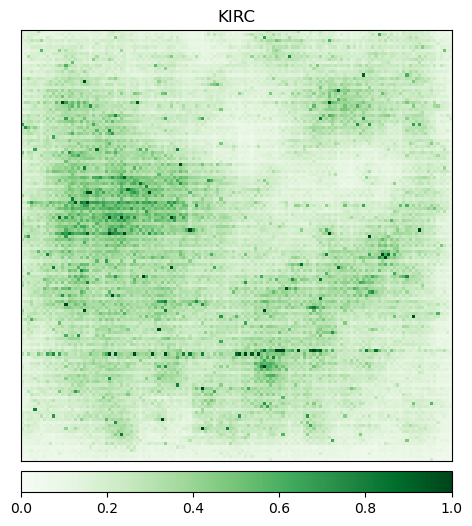

3


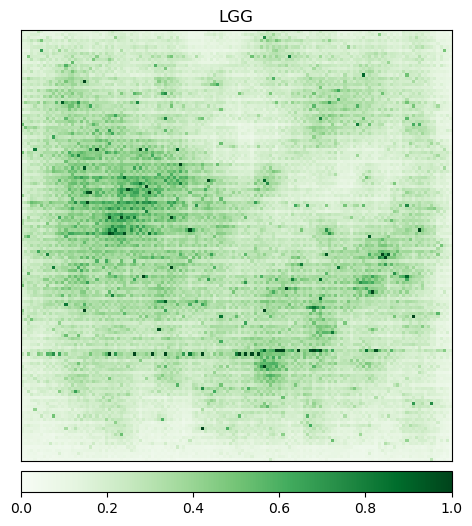

4


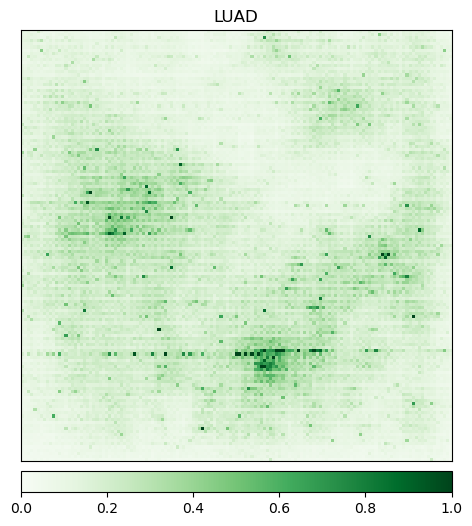

5


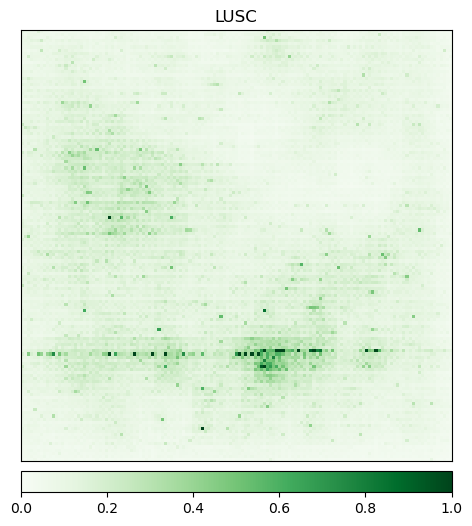

6


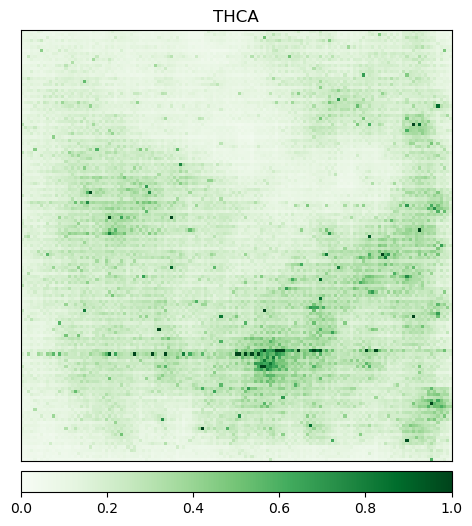

In [39]:
for ndx,mat in enumerate(sums):
#    ax = np.flip(ax_array.flatten())[ndx]
    print(ndx)
    viz.visualize_image_attr(mat,None,
                                 title=class_names[ndx],
                                 method='heat_map',
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)



In [40]:
#for attrs in results:
#    graph_for(attrs)

In [42]:
impdict={}
for imp in imps:
    for key,items in imp.items():
        itmlist=list(zip(items[0],items[1]))
        if key in impdict:
            impdict[key]=impdict[key]+itmlist
        else:
            impdict[key]=itmlist
            
#    impsorted=sorted(sum(implist,[]),key=lambda a: a[1])
for key,item in impdict.items():
    print(key, len(item))

0 200
1 200
2 200
3 200
4 200
5 200
6 200


In [43]:
#collect the same

def prep_dict(fromimp):
    res={}
    for k,v in fromimp:
        if k in res:
            res[k].append(v)
        else:
            res[k]=[v]
    return res
    

In [44]:
len(impdict[0])

200

In [61]:
def calculate_ranks_for(analysis):
    res=prep_dict(analysis)
    rank=[[key,len(vals),sum(vals)/len(vals)] for key,vals in res.items()]
    rankneg = [elm for elm in rank if elm[2]<0]
    rankpos = [elm for elm in rank if elm[2]>=0]
    rankneg = sorted(rankneg, key = lambda x: (x[1]*abs(x[2])),reverse=True)
    rankpos = sorted(rankpos, key = lambda x: (x[1]*x[2]),reverse=True)
    return (rankpos, rankneg)

In [62]:
def sort_ranks(impdict, min_occurance = 1):
    ranks={}
    for key,val in impdict.items():
        rankpos,rankneg = calculate_ranks_for(impdict[key])
        print('Pos', rankpos)
        print('Neg', rankneg)
        rankpos = [[feature_names[rank[0]]]+rank  for rank in rankpos if rank[1]>=min_occurance]
        rankneg = [[feature_names[rank[0]]]+rank for rank in rankneg if rank[1]>=min_occurance]
        ranks[key] = (rankpos,rankneg)
        print('Ranks for ',class_names[key], ' ',key)
        print('    Positive rank')
        for elm in rankpos:
            print('    ',elm[0],elm[1], elm[2]+elm[3])
        print('    --------------------------------------------------------------')
        print('    Negative rank')
        for elm in rankneg:
            print('    ',elm[0],elm[1], -1*elm[2]+abs(elm[3]))
    return(ranks)

In [63]:
ranks = sort_ranks(impdict, min_occurance = 0)

Pos [[15090, 9, 3.4310625778744e-05], [8388, 8, 2.3635251409359626e-05], [7269, 6, 2.6622109847570147e-05], [8368, 5, 2.9999113576195668e-05], [7250, 6, 2.2256279559466446e-05], [6028, 5, 2.5823278701864182e-05], [12588, 5, 2.3016125487629326e-05], [11622, 5, 2.2382203314919025e-05], [10515, 5, 2.0930504615535028e-05], [14399, 4, 2.312152173544746e-05], [10106, 4, 2.2251230348047102e-05], [11789, 3, 2.801615664793644e-05], [10612, 3, 2.4525598443384904e-05], [12050, 3, 2.442928780510556e-05], [14526, 3, 2.4410310894988168e-05], [14528, 3, 2.2742946991153683e-05], [14400, 3, 2.2371891342724364e-05], [13388, 2, 3.1998946724343114e-05], [9024, 3, 2.0296549943547387e-05], [10264, 3, 2.0077813739286892e-05], [11207, 3, 1.9654197785712313e-05], [14532, 3, 1.8875797347088035e-05], [7666, 3, 1.8576447473606095e-05], [2244, 1, 5.001798126613721e-05], [11020, 2, 2.452856642776169e-05], [14401, 2, 2.3779864022799302e-05], [5306, 2, 2.325183777429629e-05], [5332, 2, 2.2354205611918587e-05], [12464

In [64]:
def visualize_importances(rank, title="Average Feature Importances",axis_title="Features", sign=1,max_len=20):
    print(title)
    feat_names = [elm[0] for elm in rank][0:max_len]
    importances = [elm[2]+abs(elm[3]) * sign for elm in rank][0:max_len]
    print(len(feat_names))
    print(len(importances))
    x_pos = (np.arange(min(len(rank),max_len)))
    plt.figure(figsize=(12,6))
    plt.bar(x_pos, importances, align='center')
    plt.xticks(x_pos, feat_names,  rotation=90)
    plt.xlabel(axis_title)
    plt.title(title)

Ranks for  BRCA
Feature Importances for BRCA positive signals
20
20
Ranks for  HNSC
Feature Importances for HNSC positive signals
20
20
Ranks for  KIRC
Feature Importances for KIRC positive signals
20
20
Ranks for  LGG
Feature Importances for LGG positive signals
20
20
Ranks for  LUAD
Feature Importances for LUAD positive signals
20
20
Ranks for  LUSC
Feature Importances for LUSC positive signals
20
20
Ranks for  THCA
Feature Importances for THCA positive signals
20
20


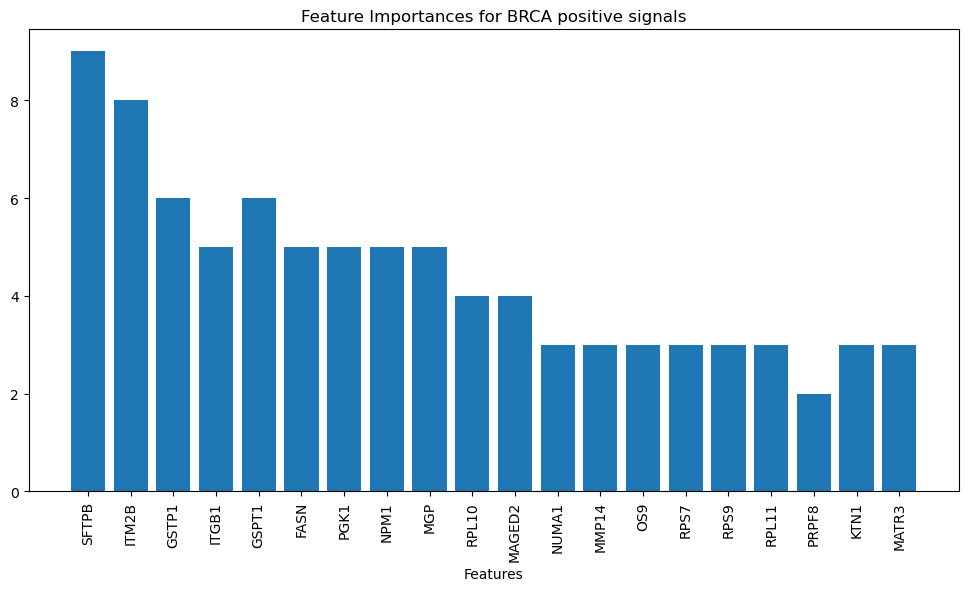

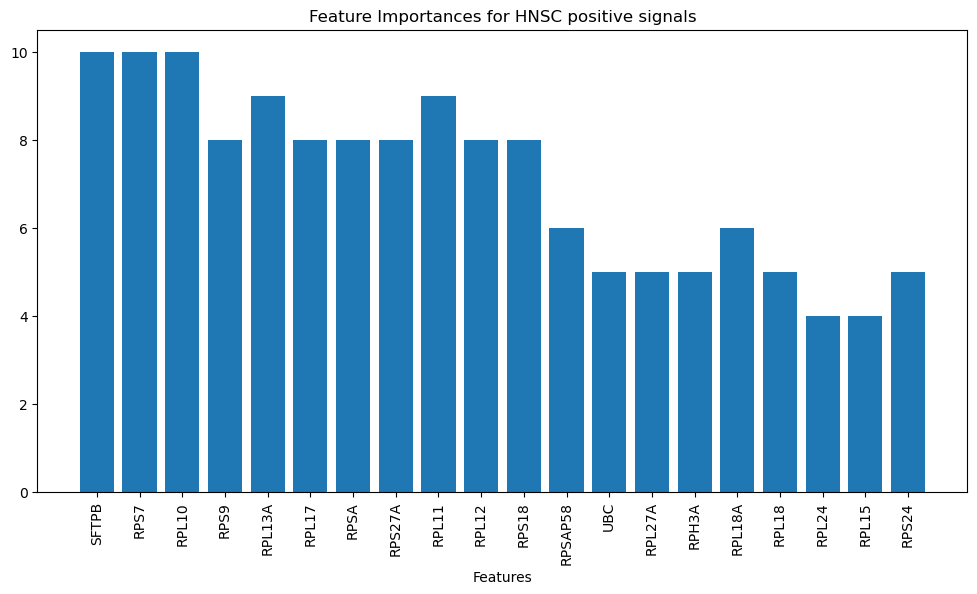

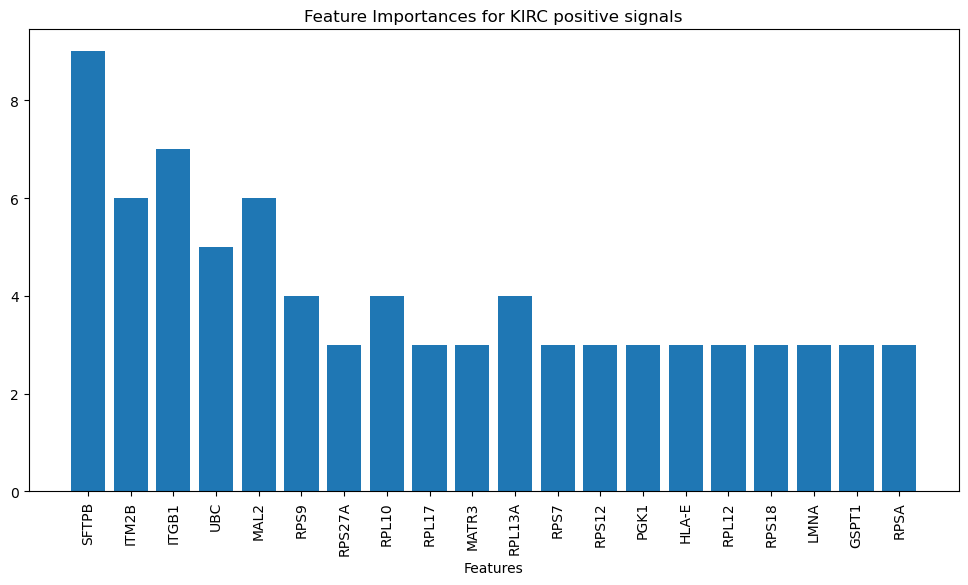

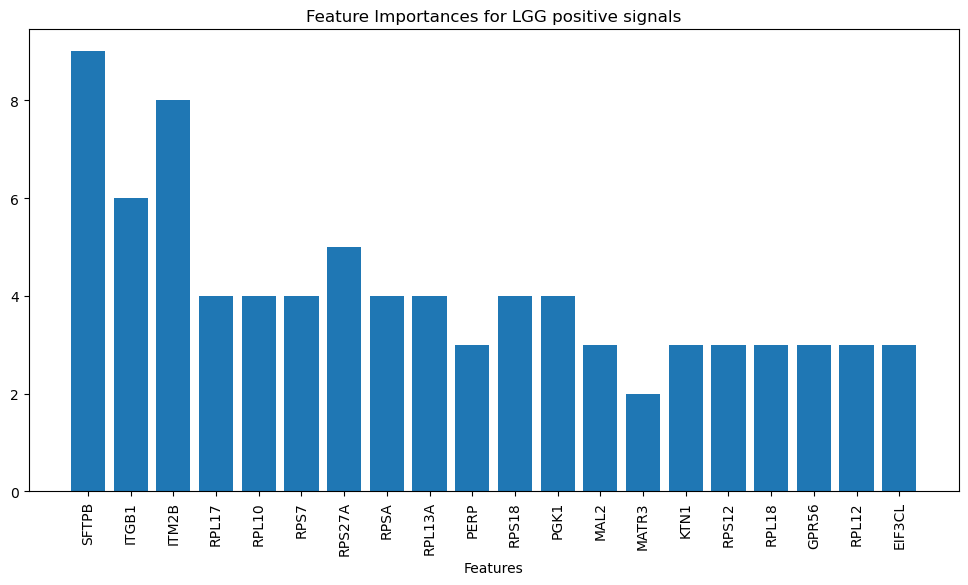

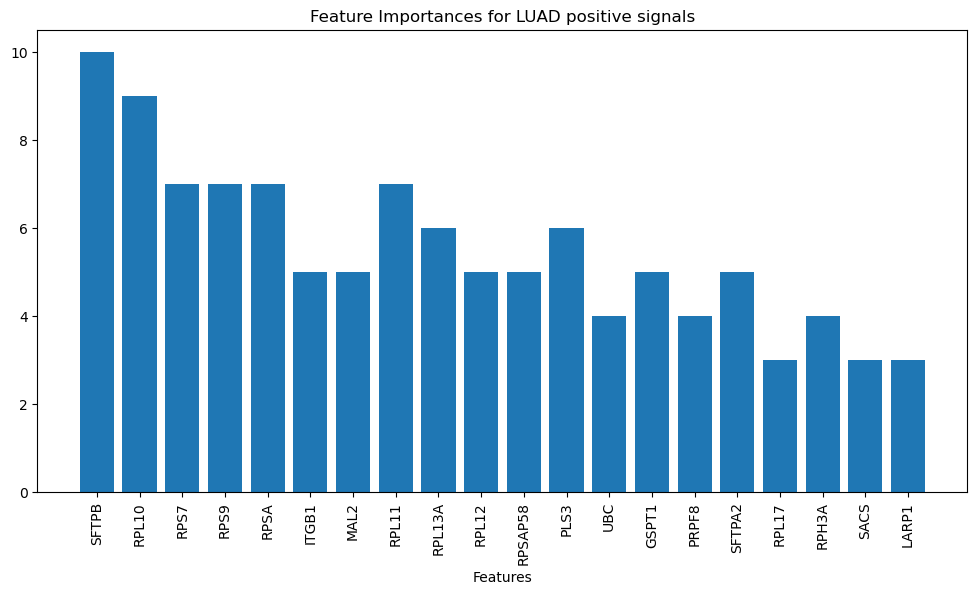

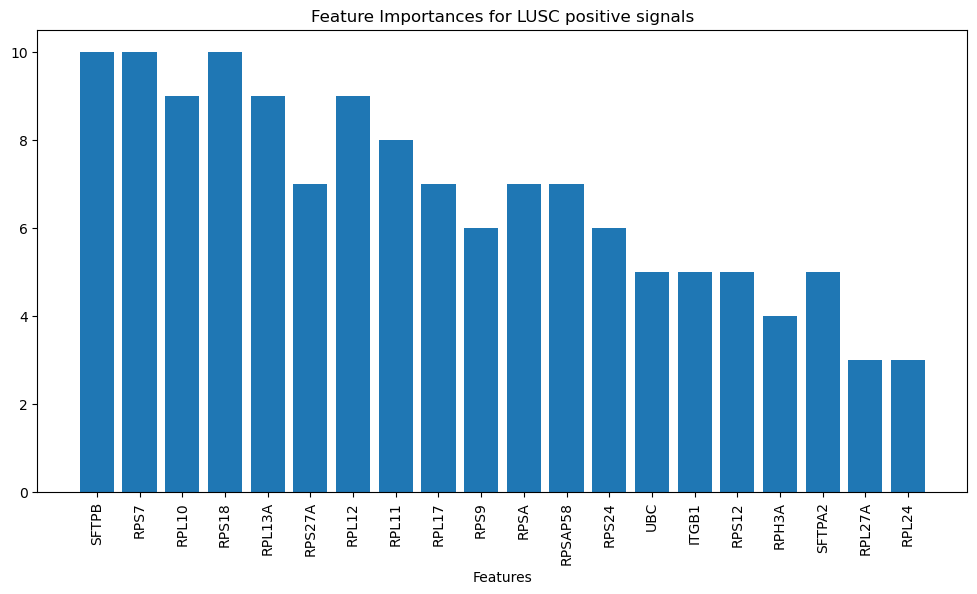

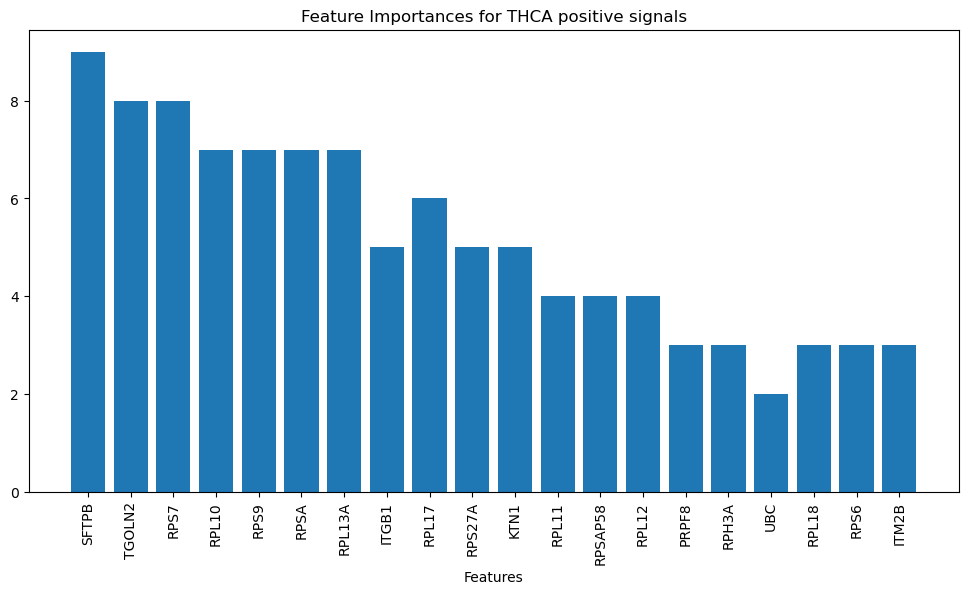

In [65]:
for key,rank in ranks.items():
    print('Ranks for ', class_names[key])
    visualize_importances(rank[0], title="Feature Importances for "+ class_names[key]+ " positive signals")
    if len(rank[1])>0:
        visualize_importances(rank[1], title="Feature Importances for "+ class_names[key]+ " negative signals", sign=-1)

In [66]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import re

In [67]:
def get_protein_interactions(protein_link):
    proteins = '%0d'.join(protein_list)
    url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
    r = requests.get(url)
    lines = r.text.split('\n') # pull the text from the response object and split based on new lines
    data = [l.split('\t') for l in lines] # split each line into its components based on tabs
    # convert to dataframe using the first row as the column names; drop empty, final row
    df = pd.DataFrame(data[1:-1], columns = data[0]) 
    # dataframe with the preferred names of the two proteins and the score of the interaction
    return df[['preferredName_A', 'preferredName_B', 'score']]

In [68]:
rankarray=[]
for key,rank in ranks.items():
    for line in rank[0]:
        print(class_names[key],',', line[0], ',', line[2]+line[3],', POSITIVE')
        rankarray.append([class_names[key], line[0], line[1], line[2],line[3]])
    for line in rank[1]:
        print(class_names[key],',', line[0], ',', -1*(line[2]+line[3]),', NEGATIVE')
        rankarray.append([class_names[key], line[0], -1*line[1], line[2],line[3]])
rankarray

BRCA , SFTPB , 9.000034310625779 , POSITIVE
BRCA , ITM2B , 8.00002363525141 , POSITIVE
BRCA , GSTP1 , 6.000026622109847 , POSITIVE
BRCA , ITGB1 , 5.000029999113576 , POSITIVE
BRCA , GSPT1 , 6.00002225627956 , POSITIVE
BRCA , FASN , 5.000025823278702 , POSITIVE
BRCA , PGK1 , 5.000023016125487 , POSITIVE
BRCA , NPM1 , 5.000022382203315 , POSITIVE
BRCA , MGP , 5.000020930504616 , POSITIVE
BRCA , RPL10 , 4.0000231215217354 , POSITIVE
BRCA , MAGED2 , 4.000022251230348 , POSITIVE
BRCA , NUMA1 , 3.000028016156648 , POSITIVE
BRCA , MMP14 , 3.0000245255984432 , POSITIVE
BRCA , OS9 , 3.000024429287805 , POSITIVE
BRCA , RPS7 , 3.000024410310895 , POSITIVE
BRCA , RPS9 , 3.000022742946991 , POSITIVE
BRCA , RPL11 , 3.0000223718913426 , POSITIVE
BRCA , PRPF8 , 2.0000319989467243 , POSITIVE
BRCA , KTN1 , 3.0000202965499434 , POSITIVE
BRCA , MATR3 , 3.000020077813739 , POSITIVE
BRCA , NCL , 3.0000196541977857 , POSITIVE
BRCA , RPSA , 3.000018875797347 , POSITIVE
BRCA , HLA-E , 3.0000185764474736 , POSI

[['BRCA', 'SFTPB', 15090, 9, 3.4310625778744e-05],
 ['BRCA', 'ITM2B', 8388, 8, 2.3635251409359626e-05],
 ['BRCA', 'GSTP1', 7269, 6, 2.6622109847570147e-05],
 ['BRCA', 'ITGB1', 8368, 5, 2.9999113576195668e-05],
 ['BRCA', 'GSPT1', 7250, 6, 2.2256279559466446e-05],
 ['BRCA', 'FASN', 6028, 5, 2.5823278701864182e-05],
 ['BRCA', 'PGK1', 12588, 5, 2.3016125487629326e-05],
 ['BRCA', 'NPM1', 11622, 5, 2.2382203314919025e-05],
 ['BRCA', 'MGP', 10515, 5, 2.0930504615535028e-05],
 ['BRCA', 'RPL10', 14399, 4, 2.312152173544746e-05],
 ['BRCA', 'MAGED2', 10106, 4, 2.2251230348047102e-05],
 ['BRCA', 'NUMA1', 11789, 3, 2.801615664793644e-05],
 ['BRCA', 'MMP14', 10612, 3, 2.4525598443384904e-05],
 ['BRCA', 'OS9', 12050, 3, 2.442928780510556e-05],
 ['BRCA', 'RPS7', 14526, 3, 2.4410310894988168e-05],
 ['BRCA', 'RPS9', 14528, 3, 2.2742946991153683e-05],
 ['BRCA', 'RPL11', 14400, 3, 2.2371891342724364e-05],
 ['BRCA', 'PRPF8', 13388, 2, 3.1998946724343114e-05],
 ['BRCA', 'KTN1', 9024, 3, 2.0296549943547387e-

In [69]:
ranksdf=pd.DataFrame(rankarray, columns=['CLASS','FEATURE NAME', 'FEATURE INDEX', 'MAJOR RANK', 'MINOR RANK'])
ranksdf.to_csv('dthomasout.csv', index=False)
ranksdf

,CLASS,FEATURE NAME,FEATURE INDEX,MAJOR RANK,MINOR RANK
0,BRCA,SFTPB,15090,9,0.000034
1,BRCA,ITM2B,8388,8,0.000024
2,BRCA,GSTP1,7269,6,0.000027
3,BRCA,ITGB1,8368,5,0.000030
4,BRCA,GSPT1,7250,6,0.000022
...,...,...,...,...,...
642,THCA,RPS14,14486,1,0.000010
643,THCA,PCDP1,12366,1,0.000010
644,THCA,PKM2,12783,1,0.000010
645,THCA,RPLP0,14464,1,0.000010


In [70]:
proteins = {}
for key,rank in ranks.items():
    protein_list = [elm[0] for elm in rank[0]]
    protein_list = [re.split('[ \.]', pn) [0] for pn in protein_list]
    proteins[key] = protein_list
proteins

{0: ['SFTPB',
  'ITM2B',
  'GSTP1',
  'ITGB1',
  'GSPT1',
  'FASN',
  'PGK1',
  'NPM1',
  'MGP',
  'RPL10',
  'MAGED2',
  'NUMA1',
  'MMP14',
  'OS9',
  'RPS7',
  'RPS9',
  'RPL11',
  'PRPF8',
  'KTN1',
  'MATR3',
  'NCL',
  'RPSA',
  'HLA-E',
  'C20orf3',
  'MYL6',
  'RPL12',
  'EIF3CL',
  'EIF4G2',
  'PDIA3P',
  'LAPTM4A',
  'GOLM1',
  'MAL2',
  'LMNA',
  'PARP14',
  'GSN',
  'GLO1',
  'APP',
  'NETO1',
  'RPS18',
  'ENSA',
  'LARP1',
  'GLDN',
  'AZGP1',
  'NET1',
  'NAA40',
  'RPL17',
  'RPS27A',
  'ETNK2',
  'FLJ37453',
  'DNAH14',
  'SACS',
  'FLJ36777',
  'AHNAK',
  'CD151',
  'RPL18',
  'EIF3A',
  'RPL13A',
  'RPS12',
  'CTNNA1',
  'EIF1',
  'NUFIP2',
  'ST13',
  'NAA30',
  'LDHA',
  'FCGRT',
  'GAB4',
  'FANCC',
  'MGEA5',
  'PLD3',
  'PTMA',
  'SCNN1B',
  'RPL27A',
  'NEU1',
  'RPL18A',
  'RPSAP58',
  'XBP1',
  'PDIA3',
  'PLS3',
  'PDIA4',
  'RPS24',
  'NCOA4',
  'HMGCLL1',
  'RPS14',
  'IBSP',
  'NCOR2',
  'CTSD',
  'FOXM1',
  'TGM2',
  'HMGB3L1',
  'G6PD',
  'LAP3',
  'MCM

In [76]:
def rescale(l,newmin,newmax):
    arr = list(l)
    return [(x-min(arr))/(max(arr)-min(arr))*(newmax-newmin)+newmin for x in arr]

def draw_interactions(interactions):
    G=nx.Graph(name='Protein Interaction Graph')
    interactions = np.array(interactions)
    for i in range(len(interactions)):
        interaction = interactions[i]
        a = interaction[0] # protein a node
        b = interaction[1] # protein b node
        w = float(interaction[2]) # score as weighted edge where high scores = low weight
        G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph
    pos = nx.spring_layout(G) # position the nodes using the spring layout
#    plt.figure(figsize=(11,11),facecolor=[0.7,0.7,0.7,0.4])
#    nx.draw_networkx(G)
#    plt.axis('off')
#    plt.show()
    c = rescale([G.degree(v) for v in G],0.0,0.9) 
    c = [graph_colormap(i) for i in c]
    # node size varies with betweeness centrality - map to range [10,100] 
    bc = nx.betweenness_centrality(G) # betweeness centrality
    s =  rescale([v for v in bc.values()],1500,7000)
    # edge width shows 1-weight to convert cost back to strength of interaction 
    ew = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,4)
    # edge color also shows weight
    ec = rescale([float(G[u][v]['weight']) for u,v in G.edges],0.1,1)
    ec = [graph_colormap(i) for i in ec]

    pos = nx.spring_layout(G)
    plt.figure(figsize=(19,9),facecolor=[0.7,0.7,0.7,0.4])
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=c, node_size=s,edge_color= ec,width=ew,
                     font_color='white',font_weight='bold',font_size='9')
    plt.axis('off')
    plt.show()    

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


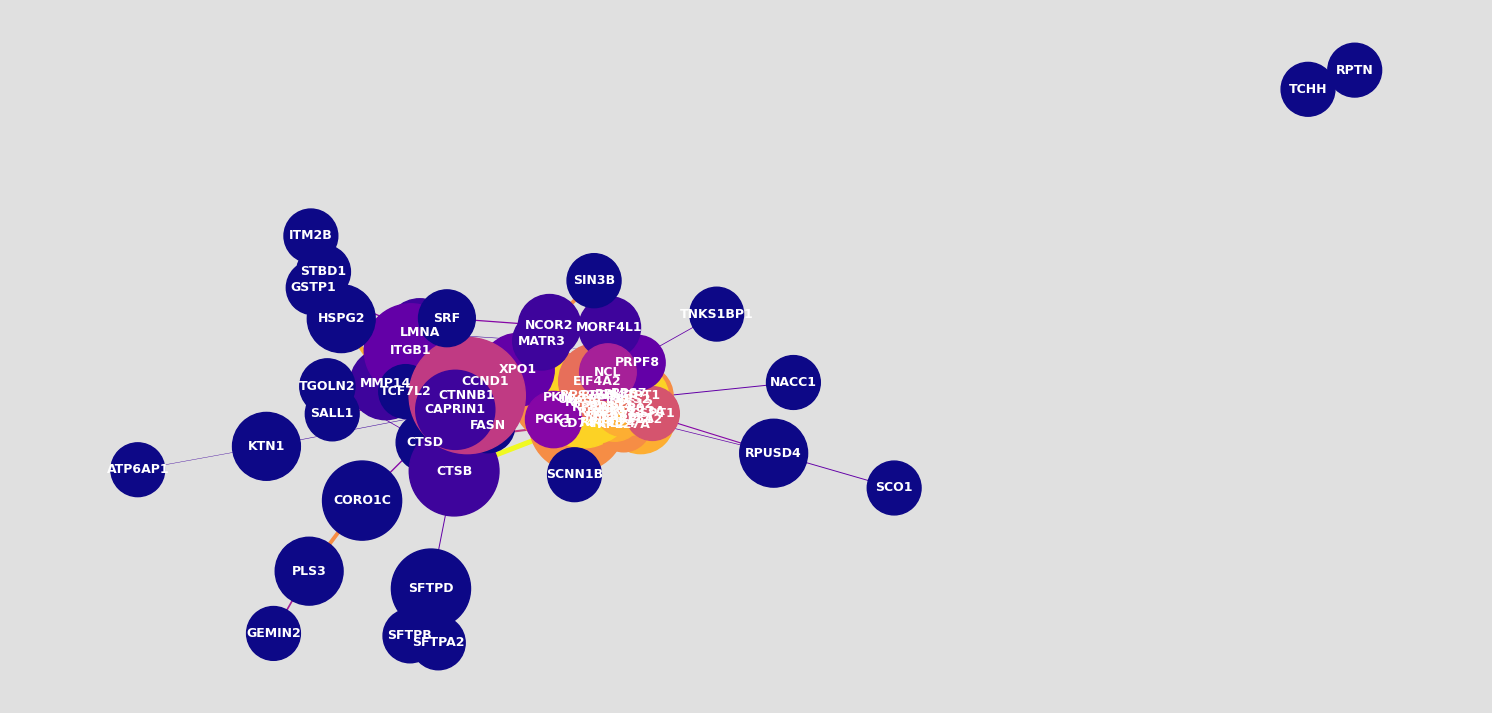

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


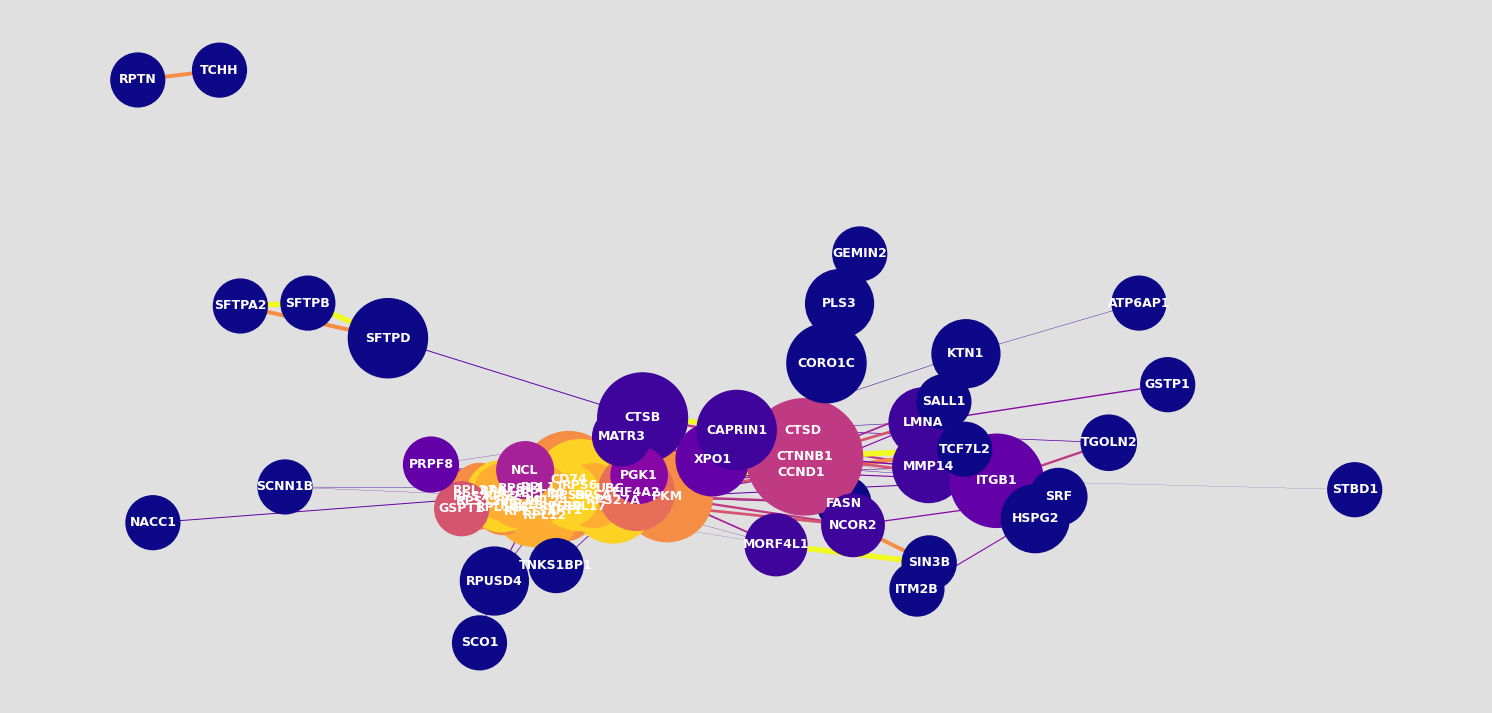

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


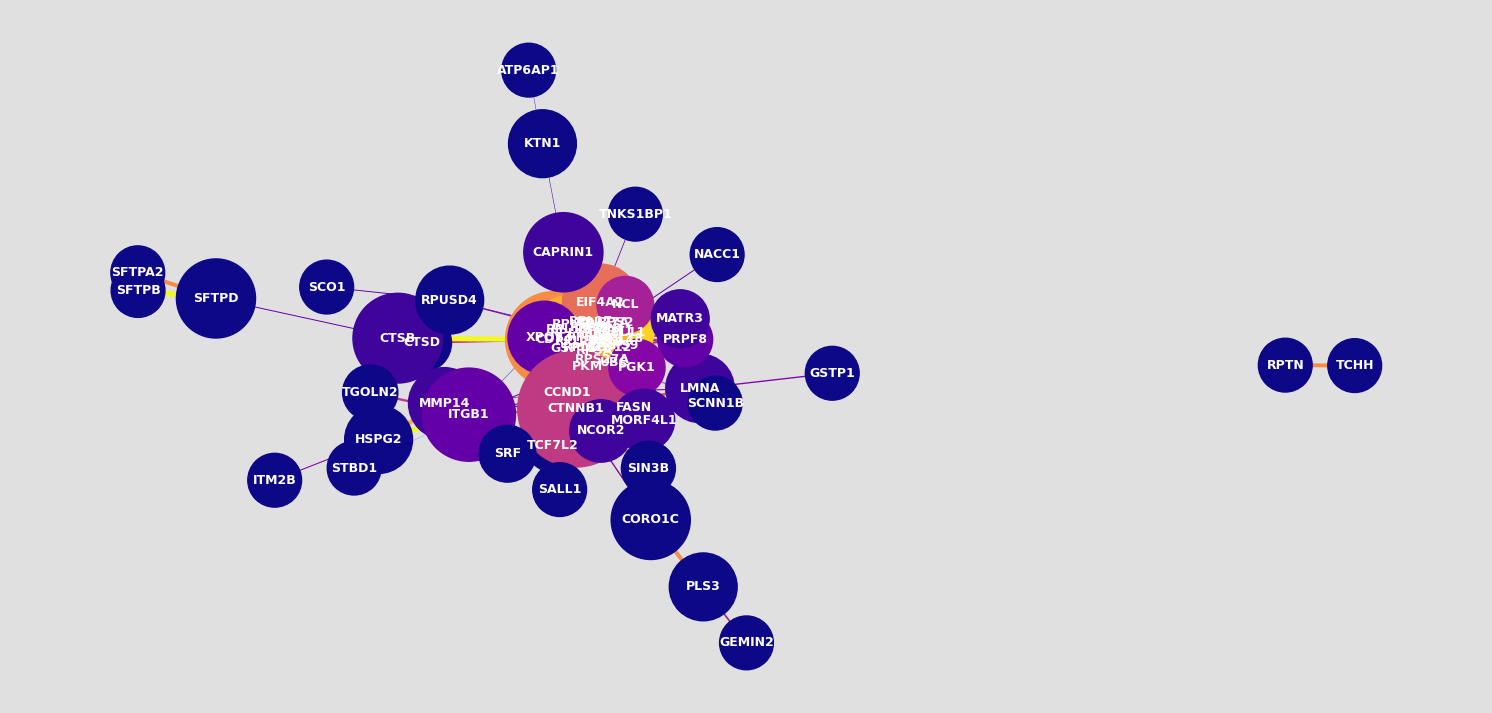

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


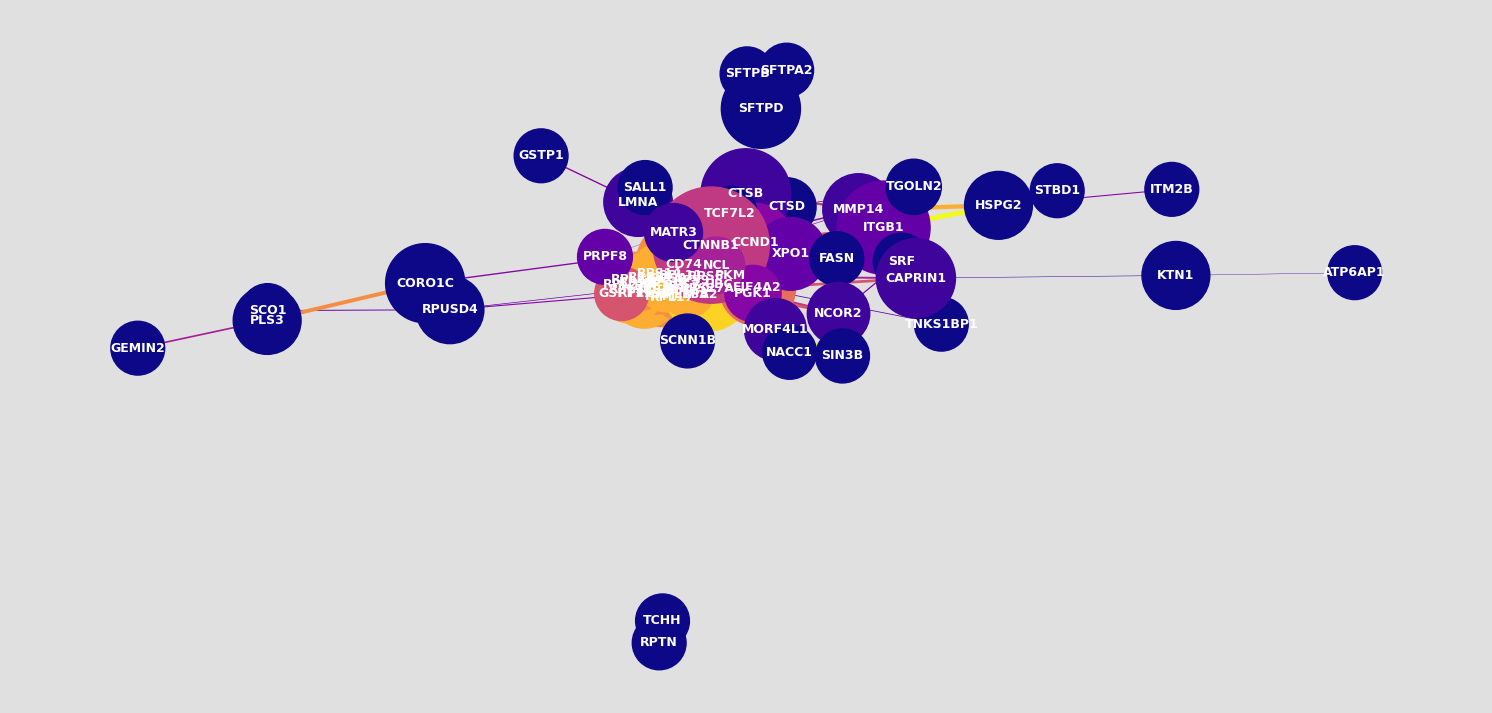

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


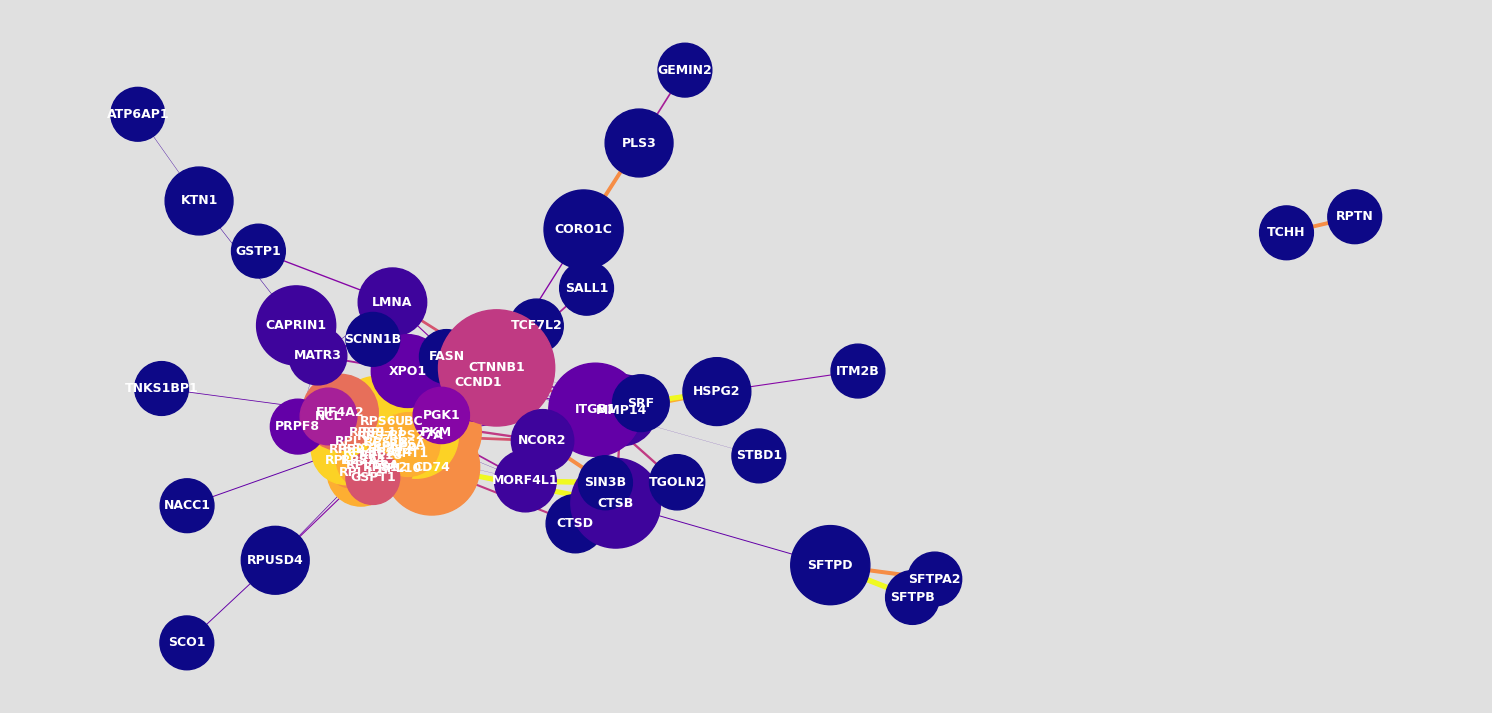

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


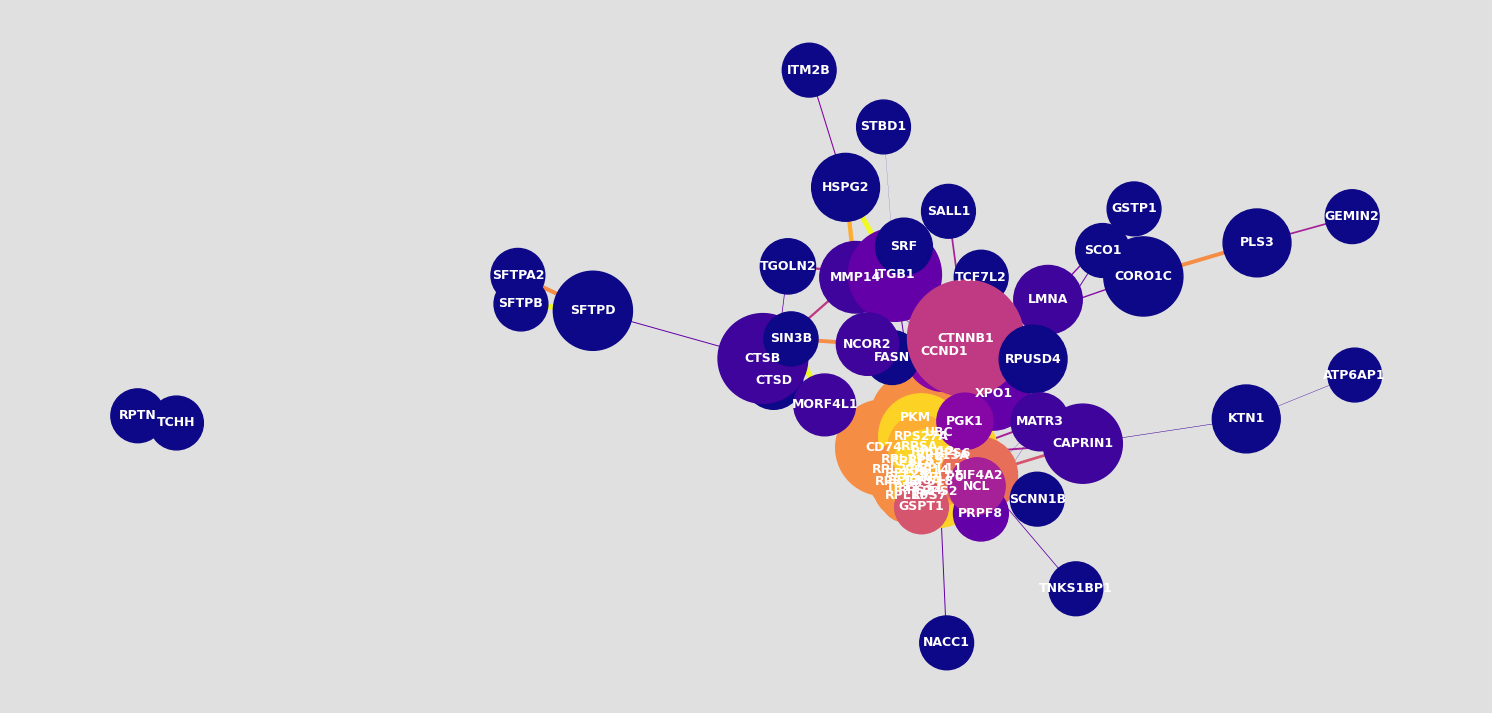

    preferredName_A preferredName_B  score
0              CD74             UBC  0.607
1              CD74            CTSD  0.615
2              CD74             PKM  0.635
3              CD74           RPS14  0.695
4              CD74            TPT1  0.851
..              ...             ...    ...
412           RPL17            RPS7  0.999
413            TPT1            RPS7  0.954
414            TPT1           RPL11  0.961
415          TCF7L2          CTNNB1  0.999
416            RPS7           RPL11  0.999

[417 rows x 3 columns]


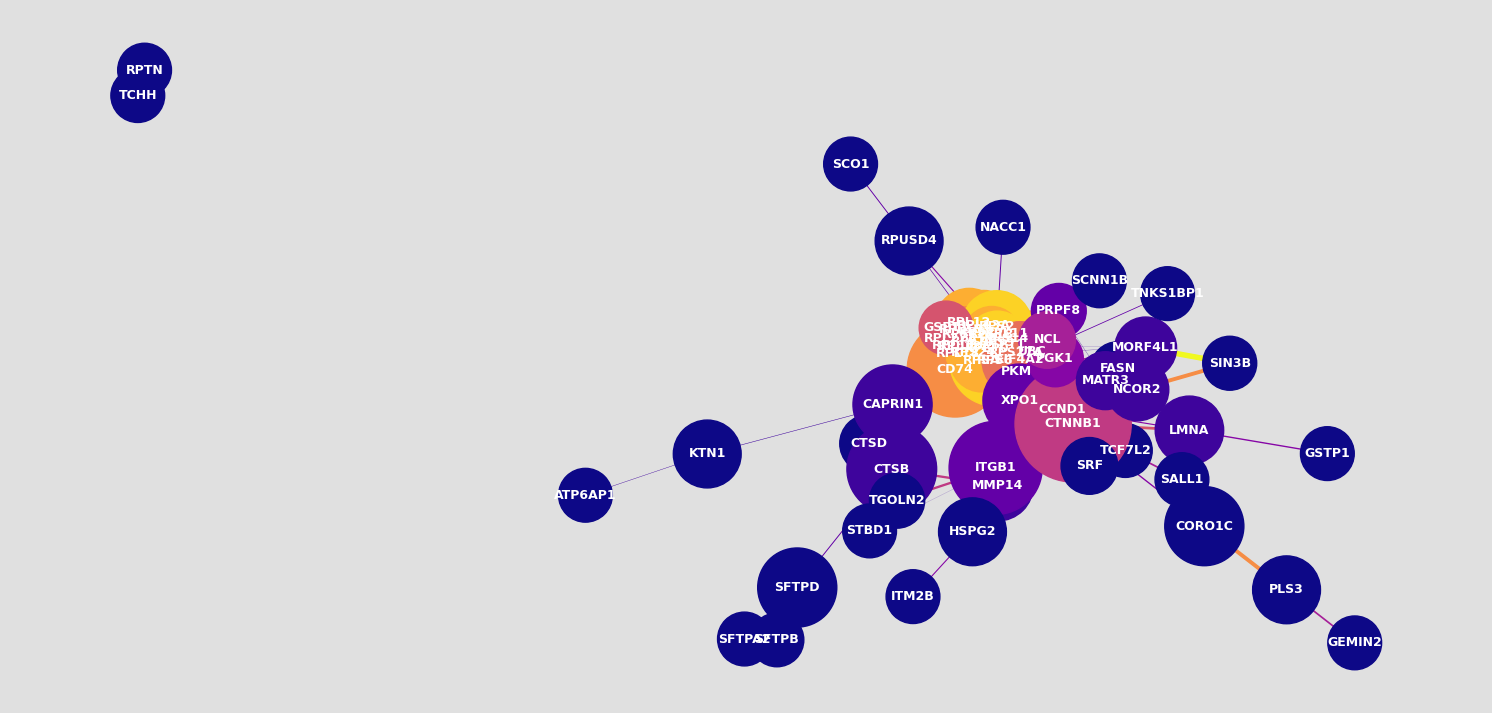

In [78]:
graph_colormap = cm.get_cmap('plasma', 12)
for key,lst in proteins.items():
    interactions = get_protein_interactions(lst)
    print(interactions)
    draw_interactions(interactions)